### 커스텀 데이터 셋

In [1]:
import json
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import os
import torch
import torchvision.transforms as T
from skimage.draw import polygon2mask
import cv2

class CustomDataset(Dataset):
    def __init__(self, img_dir, ann_dir, transforms=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.transforms = transforms
        
        # 클래스 ID 및 레이블 매핑 정의
        self.id2label = {
            0: 'background',
            1: 'common_road',
            2: 'common_tree',
            3: 'field_corps',
            4: 'field_furrow',
            5: 'field_levee',
            6: 'orchard_road',
            7: 'orchard_tree',
            8: 'paddy_after_driving',
            9: 'paddy_before_driving',
            10: 'paddy_edge',
            11: 'paddy_rice',
            12: 'paddy_water'
        }
        
        self.label2id = {v: k for k, v in self.id2label.items()}  # 레이블을 ID로 매핑

        self.label_list = os.listdir(self.ann_dir)
        self.img_paths = []
        self.ann_paths = []
        
        # 미리 경로 계산
        for label in self.label_list:
            with open(os.path.join(self.ann_dir, label), 'r', encoding='utf-8') as f:
                img_info = json.load(f)
            img_path = os.path.join(self.img_dir, img_info['name'])
            self.img_paths.append(img_path)
            self.ann_paths.append(os.path.join(self.ann_dir, label))

    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        ann_path = self.ann_paths[idx]
        
        with open(ann_path, 'r', encoding='utf-8') as f:
            img_info = json.load(f)
        
        image = Image.open(img_path).convert('RGB')
        mask = np.full((image.height, image.width), 0, dtype=np.int32)  # 초기값을 0으로 설정
        
        for obj in img_info['objects']:
            class_id = self.get_class_index(obj['label'])
            for pos in obj['position']:
                coords = [(y, x) for x, y in zip(pos[::2], pos[1::2])] #pos[::2]는 짝수 인덱스(모든 x 좌표), pos[1::2]는 홀수 인덱스(모든 y 좌표)
                # print(f"Coords for {obj['label']} with class ID {class_id}: {coords}")  # 디버깅용 좌표 출력

                 # 좌표가 이미지 경계를 벗어나는지 확인
                out_of_bounds_coords = [(x, y) for y, x in coords if x < 0 or x >= image.width or y < 0 or y >= image.height]
                if out_of_bounds_coords:
                    #print(f"Warning: Some coordinates for {obj['label']} are out of image bounds: {out_of_bounds_coords}")
                    coords = [(max(0, min(image.height - 0.1, y)), max(0, min(image.width - 0.1, x))) for y, x in coords] # 이미지 벗어나는 좌표 클리핑

            

                poly_mask = polygon2mask((image.height, image.width), coords)

                # 디버깅용으로 poly_mask가 True인 위치 출력
                # true_indices = np.where(poly_mask)
                # true_positions = list(zip(true_indices[0], true_indices[1]))
                # print(f"True positions in poly_mask: {true_positions[:10]}")  # 처음 10개의 위치만 출력

                mask[poly_mask] = class_id

                # # 개별 마스크 시각화(디버깅)
                # plt.figure(figsize=(6, 6))
                # plt.imshow(mask, cmap='gray')
                # plt.title(f"{obj['label']} with class ID {class_id}")
                # plt.show()
                
        if self.transforms:
            augmented = self.transforms(image=np.array(image), mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        

        return image, mask

        # if self.transforms:
        #     image = self.transforms(image)
        
        # mask = torch.tensor(mask, dtype=torch.long)

        # return image, mask

    def get_class_index(self, label):
        return self.label2id.get(label, 0)  # 기본값 0 (배경)







### 작은 데이터 셋 사용 테스트

In [11]:
from torch.utils.data import DataLoader
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2 

train_transforms = A.Compose([
    A.OneOf([
        A.HorizontalFlip(p=0.5),
    ], p=1.0),
    A.OneOf([
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.5),
        A.ColorJitter(p=0.5),
    ], p=1.0),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.GaussianBlur(blur_limit=3, p=0.1),
        A.GaussNoise(p=0.2),
    ], p=1.0),
    A.OneOf([
        A.RandomRain(p=0.2),
        A.RandomSnow(p=0.2),
        A.RandomFog(p=0.2),
        A.RandomShadow(p=0.2),
    ], p=1.0),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])


c:\Users\USER\anaconda3\envs\torch_seg\lib\site-packages\pydantic\main.py:176: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)


In [12]:
train_dataset = CustomDataset("C:/Users/USER/Desktop/resized_train_image", "C:/Users/USER/Desktop/resized_train_annotations", transforms=train_transforms)
val_dataset = CustomDataset("C:/Users/USER/Desktop/resized_valid_image", "C:/Users/USER/Desktop/resized_valid_annotations", transforms=val_transforms)

In [13]:
small_train_dataset = torch.utils.data.Subset(train_dataset, range(10))  # 예를 들어, 첫 10개의 데이터만 사용
small_val_dataset = torch.utils.data.Subset(val_dataset, range(10))  # 첫 10개의 검증 데이터만 사용


In [14]:
# 작은 데이터셋을 사용하는 DataLoader 설정
from torch.utils.data import DataLoader

train_loader = DataLoader(small_train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(small_val_dataset, batch_size=2, shuffle=False)

In [2]:
from torch.utils.data import DataLoader
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2 

# ### Data augmentation을 고려할 필요가 있음

# train_transforms = T.Compose([
#     T.ToTensor(),
#     T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# val_transforms = T.Compose([
#     T.ToTensor(),
#     T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])


train_transforms = A.Compose([
    A.OneOf([
        A.HorizontalFlip(p=0.5),
    ], p=1.0),
    A.OneOf([
        A.RandomBrightnessContrast(p=0.5),
        A.RandomGamma(p=0.5),
        A.ColorJitter(p=0.5),
    ], p=1.0),
    A.OneOf([
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.GaussianBlur(blur_limit=3, p=0.1),
        A.GaussNoise(p=0.2),
    ], p=1.0),
    A.OneOf([
        A.RandomRain(p=0.2),
        A.RandomSnow(p=0.2),
        A.RandomFog(p=0.2),
        A.RandomShadow(p=0.2),
    ], p=1.0),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])


# DataLoader 설정
train_dataset = CustomDataset("C:/Users/USER/Desktop/512x288/resized_train_image", "C:/Users/USER/Desktop/512x288/resized_train_annotations", transforms=train_transforms)
val_dataset = CustomDataset("C:/Users/USER/Desktop/512x288/resized_valid_image", "C:/Users/USER/Desktop/512x288/resized_valid_annotations", transforms=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)

c:\Users\USER\anaconda3\envs\torch_seg\lib\site-packages\pydantic\main.py:176: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  self.__pydantic_validator__.validate_python(data, self_instance=self)


### 데이터 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Sample 1
Image shape: (1080, 1920, 3)
Mask shape: (1080, 1920)
Image path: C:/Users/USER/Desktop/train_image\NIA_AgricultureAD_field_RGB_bottom_Gyeongsangnamdo_2107211147_day_sunny_000270.jpg
Annotation path: C:/Users/USER/Desktop/train_label\NIA_AgricultureAD_field_RGB_bottom_Gyeongsangnamdo_2107211147_day_sunny_000270.json
Unique mask values: [0 1 2 9]


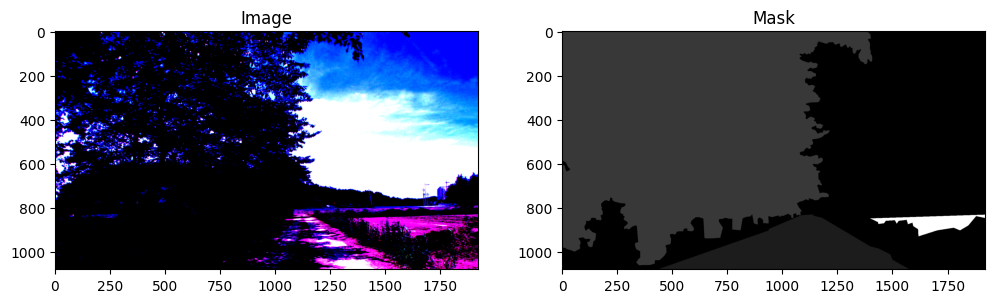

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Sample 2
Image shape: (1080, 1920, 3)
Mask shape: (1080, 1920)
Image path: C:/Users/USER/Desktop/train_image\NIA_AgricultureAD_field_RGB_bottom_Gyeongsangnamdo_2107211147_day_sunny_000273.jpg
Annotation path: C:/Users/USER/Desktop/train_label\NIA_AgricultureAD_field_RGB_bottom_Gyeongsangnamdo_2107211147_day_sunny_000273.json
Unique mask values: [0 2 9]


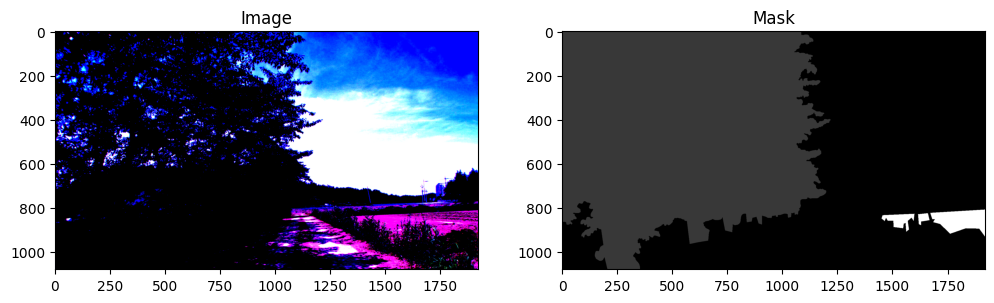

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Sample 3
Image shape: (1080, 1920, 3)
Mask shape: (1080, 1920)
Image path: C:/Users/USER/Desktop/train_image\NIA_AgricultureAD_field_RGB_bottom_Gyeongsangnamdo_2107211147_day_sunny_000292.jpg
Annotation path: C:/Users/USER/Desktop/train_label\NIA_AgricultureAD_field_RGB_bottom_Gyeongsangnamdo_2107211147_day_sunny_000292.json
Unique mask values: [0 1 2 9]


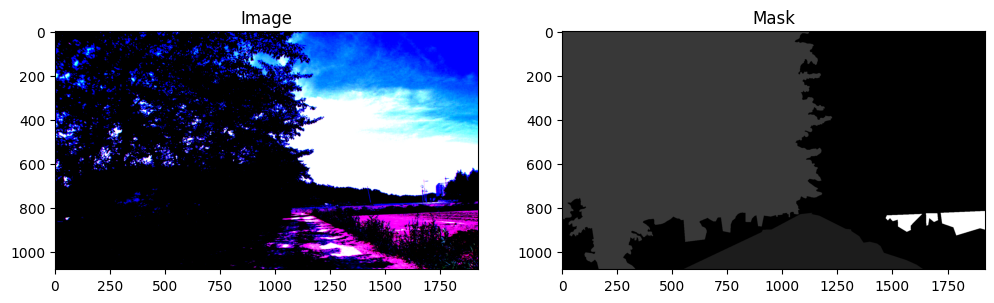

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Sample 4
Image shape: (1080, 1920, 3)
Mask shape: (1080, 1920)
Image path: C:/Users/USER/Desktop/train_image\NIA_AgricultureAD_field_RGB_bottom_Gyeongsangnamdo_2107211147_day_sunny_000295.jpg
Annotation path: C:/Users/USER/Desktop/train_label\NIA_AgricultureAD_field_RGB_bottom_Gyeongsangnamdo_2107211147_day_sunny_000295.json
Unique mask values: [0 1 2 9]


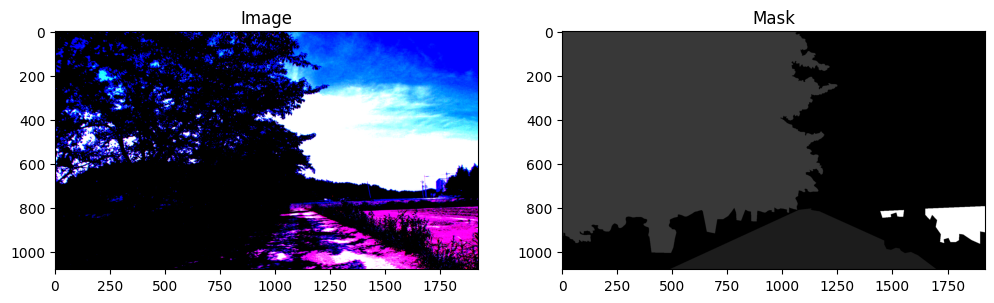

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Sample 5
Image shape: (1080, 1920, 3)
Mask shape: (1080, 1920)
Image path: C:/Users/USER/Desktop/train_image\NIA_AgricultureAD_field_RGB_bottom_Gyeongsangnamdo_2107211147_day_sunny_000308.jpg
Annotation path: C:/Users/USER/Desktop/train_label\NIA_AgricultureAD_field_RGB_bottom_Gyeongsangnamdo_2107211147_day_sunny_000308.json
Unique mask values: [0 1 2 9]


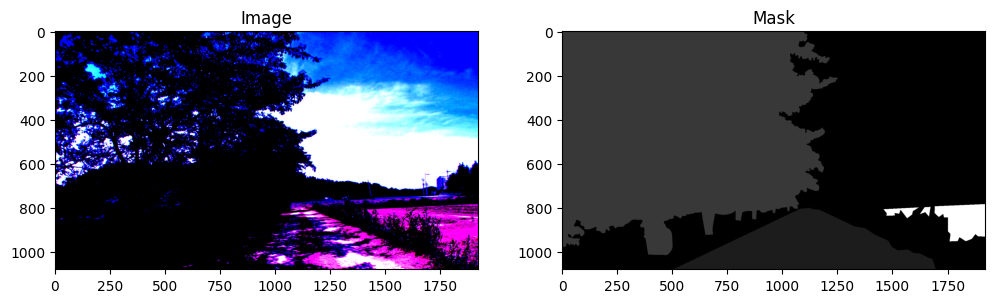

In [5]:
# 이미지 변환 설정
import matplotlib.pyplot as plt
train_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 데이터셋 설정
train_dataset = CustomDataset(
    "C:/Users/USER/Desktop/train_image", 
    "C:/Users/USER/Desktop/train_label", 
    transforms=train_transforms
)

def check_sample_data(dataset, num_samples=5):
    for i in range(num_samples):
        idx = 1 + i

        image, mask = dataset[i]
        
        image_np = image.numpy().transpose(1, 2, 0)
        mask_np = mask.numpy()
        
        print(f"Sample {i+1}")
        print("Image shape:", image_np.shape)
        print("Mask shape:", mask_np.shape)
        print("Image path:", dataset.img_paths[idx])
        print("Annotation path:", dataset.ann_paths[idx])
        print("Unique mask values:", np.unique(mask_np))
        
        plt.figure(figsize=(12, 6))
        
        plt.subplot(1, 2, 1)
        plt.imshow(image_np)
        plt.title("Image")
        
        plt.subplot(1, 2, 2)
        plt.imshow(mask_np, cmap='gray')
        plt.title("Mask")
        
        plt.show()

# 샘플 데이터 확인 실행
check_sample_data(train_dataset)

In [ ]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(val_dataset))

Number of training examples: 71418
Number of validation examples: 24468


### 모델 설정

In [3]:
# 클래스 ID 및 레이블 매핑 정의
id2label = {
            0: 'background',
            1: 'common_road',
            2: 'common_tree',
            3: 'field_corps',
            4: 'field_furrow',
            5: 'field_levee',
            6: 'orchard_road',
            7: 'orchard_tree',
            8: 'paddy_after_driving',
            9: 'paddy_before_driving',
            10: 'paddy_edge',
            11: 'paddy_rice',
            12: 'paddy_water'
        }
# 반대 매핑 생성
label2id = {v: k for k, v in id2label.items()}


In [4]:
# Pre-trained models
# MODEL_CHECKPOINT = 'nvidia/mit-b0'
# MODEL_CHECKPOINT = 'nvidia/mit-b1'
# MODEL_CHECKPOINT = 'nvidia/mit-b2'
MODEL_CHECKPOINT = 'nvidia/mit-b3'
# MODEL_CHECKPOINT = 'nvidia/mit-b4'
# MODEL_CHECKPOINT = 'nvidia/mit-b5'
# MODEL_CHECKPOINT = 'nvidia/segformer-b4-finetuned-cityscapes-1024-1024'


LR = 0.00006



In [5]:
from transformers import SegformerForSemanticSegmentation


# 모델 초기화
model = SegformerForSemanticSegmentation.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=len(id2label),  # 클래스 수 지정
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # 사전 훈련된 모델과 크기 불일치 무시
)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_name = "nvidia/segformer-b3-finetuned-cityscapes-1024-1024"
# model = SegformerForSemanticSegmentation.from_pretrained(model_name)

# # 모델의 헤드 클래스 수를 변경
# model.config.num_labels = 13  # fine-tuning 데이터셋의 클래스 수에 맞게 변경
# model.decode_head.classifier = torch.nn.Conv2d(768, model.config.num_labels, kernel_size=1)  # 768은 B3의 내부 차원 수
# model.load_state_dict(torch.load("C:/Users/USER/Downloads/512288.pth", map_location=device))



c:\Users\USER\anaconda3\envs\torch_seg\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b3 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should proba

### 최종 훈련코드

In [6]:
# start_epoch = 6  # 시작 에폭 설정
# num_epochs = 10  # 총 학습 에폭 설정
import wandb
wandb.init(project="farm_final", id='b3_final')

# # wandb 초기화
# wandb.init(project="uncategorized_project", resume="allow", id="lemon-cherry-45")
# wandb.config.update({
#     "epochs": num_epochs,
#     "batch_size": 16,
#     "start_epoch": start_epoch,
#     "learning_rate": 0.00006,
# })

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chldyddn98 (choiyw). Use `wandb login --relogin` to force relogin


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader
from tqdm import tqdm
from datasets import load_metric
import wandb
import evaluate  # evaluate 라이브러리를 사용합니다

import os

# 저장할 폴더 지정 및 생성
model_save_path = "saved_models"
model_filename = "best_model.pth"
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)
full_model_path = os.path.join(model_save_path, model_filename)



# # wandb 초기화
# wandb.init(project="uncategorized_project", resume="allow", id="lemon-cherry-45")
# wandb.config.update({
#     "epochs": num_epochs,
#     "batch_size": 16,
#     "start_epoch": start_epoch,
#     "learning_rate": 0.00006,
# })

# 설정 변수
gradient_accumulation_steps = 4
best_mean_iou = 0.0

iou_metric = evaluate.load("mean_iou", trust_remote_code=True)  # evaluate 라이브러리를 사용하여 메트릭 로드

# validation
def validate_amp(model, val_loader, device, num_labels=13, ignore_index=255):
    model.eval()  # 모델을 평가 모드로 전환
    total_loss = 0
    total_correct = 0
    total_pixels = 0
    iou_metric = evaluate.load("mean_iou", trust_remote_code=True)  # 각 검증 루프마다 메트릭을 새로 초기화
    
    with torch.no_grad():  
        pbar = tqdm(total=len(val_loader), desc="Validating", unit="batch")  # tqdm을 사용하여 검증 진행 상황 표시
        for batch in val_loader:
            pixel_values = batch[0].to(device).float()  # 입력 데이터를 장치로 이동
            labels = batch[1].to(device).long()  # 라벨 데이터를 장치로 이동
            
            with autocast():  # 자동 혼합 정밀도(AMP)를 사용하여 연산
                outputs = model(pixel_values=pixel_values)  
                logits = outputs.logits  # 로짓 값
                upsampled_logits = F.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)  # 로짓을 라벨 크기로 보간
                loss = F.cross_entropy(upsampled_logits, labels, ignore_index=255)  # 교차 엔트로피 손실 계산
                
            total_loss += loss.item()  # 총 손실 계산
            predicted = upsampled_logits.argmax(dim=1)  # 예측값 계산

             # Pixel accuracy 계산
            correct = (predicted == labels).sum().item()
            total = (labels != ignore_index).sum().item()
            total_correct += correct
            total_pixels += total

            iou_metric.add_batch(predictions=predicted, references=labels)  # 메트릭에 배치 추가
            pbar.update(1) 

        pbar.close()  

    avg_loss = total_loss / len(val_loader)  # 평균 손실 계산
    mean_iou = iou_metric.compute(num_labels=num_labels, ignore_index=ignore_index)  # Mean IoU 계산
    pixel_accuracy = total_correct / total_pixels  # Pixel Accuracy 계산
    return avg_loss, mean_iou, pixel_accuracy  # 평균 손실과 Mean IoU 반환

# 모델, optimizer, device 설정
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)  # AdamW 옵티마이저 설정
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)  # AdamW 옵티마이저 설정

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # CUDA 또는 CPU 장치 설정
model.to(device)  
scaler = GradScaler()  # GradScaler 설정 (AMP를 위한 스케일러)

# 훈련 및 검증 루프
for epoch in range(10):
    model.train()  
    train_loss = 0
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/10", unit="batch")  # tqdm을 사용하여 훈련 진행 상황 표시
    for idx, batch in enumerate(train_loader):
        images, masks = batch
        # print(f"Batch {idx} - Images Shape: {images.shape}, Masks Shape: {masks.shape}")
        # print(f"Images dtype: {images.dtype}, Masks dtype: {masks.dtype}")
        # print(f"Images min: {images.min()}, max: {images.max()}")
        # print(f"Masks unique values: {torch.unique(masks)}")
        pixel_values = batch[0].to(device).float()  # 입력 데이터를 장치로 이동
        labels = batch[1].to(device).long()  # 라벨 데이터를 장치로 이동

        optimizer.zero_grad(set_to_none=True)  # 옵티마이저의 기울기 초기화

        with autocast():  # 자동 혼합 정밀도(AMP)를 사용하여 연산
            outputs = model(pixel_values=pixel_values, labels=labels)  
            loss = outputs.loss / gradient_accumulation_steps  

        scaler.scale(loss).backward()  # 스케일된 손실에 대한 역전파

        if (idx + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)  # 스케일된 파라미터로 옵티마이저 스텝
            scaler.update()  # 스케일러 업데이트
            optimizer.zero_grad()  # 옵티마이저의 기울기 초기화

        train_loss += loss.item() * gradient_accumulation_steps  # 총 훈련 손실 계산
        pbar.update(1)  
        pbar.set_postfix(batch_loss=f"{loss.item():.4f}") 

    pbar.close()  
    val_loss, mean_iou, pixel_accuracy = validate_amp(model, val_loader, device)  # 검증 함수 호출
    wandb.log({"Validation Loss": val_loss, "Mean IOU": mean_iou, "Pixel Accuracy": pixel_accuracy})  # wandb에 검증 손실 및 Mean IoU 로깅

    print(f"Validation Loss: {val_loss:.4f}, Mean IOU: {mean_iou}, Pixel Accuracy:{pixel_accuracy}")  # 검증 손실 및 Mean IoU 출력

    # 모델 저장
    if mean_iou['mean_iou'] > best_mean_iou:
        best_mean_iou = mean_iou['mean_iou']  # 최고 Mean IoU 업데이트
        torch.save(model.state_dict(), full_model_path)  # 모델 상태 저장
        print(f"Saved best model to {full_model_path}")  # 모델 저장 위치 출력


INFO:datasets:PyTorch version 2.3.1 available.
Validating:   0%|          | 0/1530 [00:00<?, ?batch/s]c:\Users\USER\anaconda3\envs\torch_seg\lib\site-packages\datasets\features\image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
Validating: 100%|██████████| 1530/1530 [19:23<00:00,  1.31batch/s] 


Validation Loss: 0.1923, Mean IOU: {'mean_iou': 0.4566796040309352, 'mean_accuracy': 0.5225717684429649, 'overall_accuracy': 0.9350752738434476, 'per_category_iou': array([0.9348021 , 0.87659487, 0.32631787, 0.        , 0.12133803,
       0.46002709, 0.71021849, 0.83008636, 0.75846788, 0.01649524,
       0.19598221, 0.70650472, 0.        ]), 'per_category_accuracy': array([0.9789069 , 0.92546653, 0.4387858 , 0.        , 0.12974254,
       0.63960989, 0.93278372, 0.93979004, 0.8511356 , 0.01656256,
       0.19812688, 0.74252253, 0.        ])}, Pixel Accuracy:0.9350752738434476
Saved best model to saved_models\best_model.pth


Validating: 100%|██████████| 1530/1530 [21:29<00:00,  1.19batch/s] 


Validation Loss: 0.1704, Mean IOU: {'mean_iou': 0.4969361952624756, 'mean_accuracy': 0.5582337676612842, 'overall_accuracy': 0.9429470927912825, 'per_category_iou': array([0.94113846, 0.88892455, 0.30272818, 0.        , 0.27369841,
       0.45156359, 0.76076075, 0.83742796, 0.81020459, 0.10602556,
       0.33736612, 0.75033236, 0.        ]), 'per_category_accuracy': array([0.98143166, 0.92662681, 0.41581941, 0.        , 0.36653154,
       0.50138525, 0.9523368 , 0.95437893, 0.91764551, 0.10950809,
       0.34583587, 0.7855391 , 0.        ])}, Pixel Accuracy:0.9429470927912825
Saved best model to saved_models\best_model.pth


Validating: 100%|██████████| 1530/1530 [21:02<00:00,  1.21batch/s] 


Validation Loss: 0.1856, Mean IOU: {'mean_iou': 0.49962369800739526, 'mean_accuracy': 0.5554390759195615, 'overall_accuracy': 0.9435208632272892, 'per_category_iou': array([0.94134506, 0.89880652, 0.20942922, 0.        , 0.27278596,
       0.54005433, 0.78488572, 0.84245466, 0.81185706, 0.02527211,
       0.45741407, 0.71080338, 0.        ]), 'per_category_accuracy': array([0.98097568, 0.93949618, 0.33001399, 0.        , 0.3246117 ,
       0.64975572, 0.89737189, 0.93958093, 0.91446194, 0.0254181 ,
       0.48238539, 0.73663648, 0.        ])}, Pixel Accuracy:0.9435208632272892
Saved best model to saved_models\best_model.pth


Validating: 100%|██████████| 1530/1530 [21:58<00:00,  1.16batch/s] 


Validation Loss: 0.1834, Mean IOU: {'mean_iou': 0.5101606014872229, 'mean_accuracy': 0.5889935691292612, 'overall_accuracy': 0.9423428064401435, 'per_category_iou': array([0.94081196, 0.89795692, 0.2439437 , 0.        , 0.27768675,
       0.54071384, 0.76853202, 0.83992123, 0.81001885, 0.08038889,
       0.49472569, 0.73738799, 0.        ]), 'per_category_accuracy': array([0.972566  , 0.95278001, 0.47821199, 0.        , 0.33755829,
       0.72963846, 0.92804993, 0.96468318, 0.91923714, 0.08165422,
       0.52747063, 0.76506655, 0.        ])}, Pixel Accuracy:0.9423428064401435
Saved best model to saved_models\best_model.pth


Validating: 100%|██████████| 1530/1530 [20:58<00:00,  1.22batch/s] 


Validation Loss: 0.1910, Mean IOU: {'mean_iou': 0.4901017773703603, 'mean_accuracy': 0.5533429986422138, 'overall_accuracy': 0.9428307340270399, 'per_category_iou': array([0.94198992, 0.89547468, 0.19102834, 0.        , 0.23617654,
       0.55563656, 0.76399351, 0.84022862, 0.79506454, 0.04130658,
       0.36160616, 0.74881763, 0.        ]), 'per_category_accuracy': array([0.97837522, 0.94488984, 0.26799755, 0.        , 0.27105418,
       0.72157757, 0.95597   , 0.95827707, 0.89973302, 0.04158788,
       0.36802483, 0.78597182, 0.        ])}, Pixel Accuracy:0.9428307340270399


Validating: 100%|██████████| 1530/1530 [21:10<00:00,  1.20batch/s] 


Validation Loss: 0.2067, Mean IOU: {'mean_iou': 0.5156470529224995, 'mean_accuracy': 0.5954598910268752, 'overall_accuracy': 0.9439783125935534, 'per_category_iou': array([0.94387047, 0.89417496, 0.25185294, 0.        , 0.34274317,
       0.54511251, 0.77205962, 0.83843683, 0.80063635, 0.04374298,
       0.47857006, 0.79221181, 0.        ]), 'per_category_accuracy': array([0.97359853, 0.96370572, 0.46829353, 0.        , 0.44795458,
       0.65495069, 0.9599604 , 0.95528993, 0.92726257, 0.04414871,
       0.51311942, 0.8326945 , 0.        ])}, Pixel Accuracy:0.9439783125935534
Saved best model to saved_models\best_model.pth


Validating: 100%|██████████| 1530/1530 [21:05<00:00,  1.21batch/s] 


Validation Loss: 0.2141, Mean IOU: {'mean_iou': 0.49307922339306454, 'mean_accuracy': 0.566275100889208, 'overall_accuracy': 0.9388929905493946, 'per_category_iou': array([0.9410256 , 0.87095718, 0.23943372, 0.        , 0.32176523,
       0.57430172, 0.63030078, 0.84354674, 0.73572013, 0.15408175,
       0.34773152, 0.75116553, 0.        ]), 'per_category_accuracy': array([0.97915451, 0.95217861, 0.35362219, 0.        , 0.39740728,
       0.74070457, 0.88873072, 0.94449809, 0.81330773, 0.15974623,
       0.35505262, 0.77717375, 0.        ])}, Pixel Accuracy:0.9388929905493946


Validating: 100%|██████████| 1530/1530 [31:16<00:00,  1.23s/batch] 


Validation Loss: 0.1878, Mean IOU: {'mean_iou': 0.5139414751218474, 'mean_accuracy': 0.585172651513144, 'overall_accuracy': 0.9455314828721868, 'per_category_iou': array([0.94482584, 0.89049191, 0.24338327, 0.        , 0.27712706,
       0.57971955, 0.75867008, 0.82783436, 0.81119733, 0.06731521,
       0.50915746, 0.77151711, 0.        ]), 'per_category_accuracy': array([0.97518171, 0.96916875, 0.31658914, 0.        , 0.31772237,
       0.78943813, 0.94426858, 0.972226  , 0.90787937, 0.06849765,
       0.54536721, 0.80090556, 0.        ])}, Pixel Accuracy:0.9455314828721868


Epoch 9/10:  13%|█▎        | 574/4464 [1:22:49<7:13:10,  6.68s/batch, batch_loss=0.0102]

KeyboardInterrupt: 

In [ ]:
start_epoch = 9  # 시작 에폭 설정
num_epochs = 10  # 총 학습 에폭 설정

import wandb
wandb.init(project="farm_final", id='b3_final')

wandb.config.update({
    "epochs": num_epochs,
    "batch_size": 16,
    "start_epoch": start_epoch,
    "learning_rate": 0.00006,
})

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader
from tqdm import tqdm
from datasets import load_metric
import evaluate  # evaluate 라이브러리를 사용합니다
import os

# 저장할 폴더 지정 및 생성
model_save_path = "saved_models"
model_filename = "best_model.pth"
if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)
full_model_path = os.path.join(model_save_path, model_filename)

# 설정 변수
gradient_accumulation_steps = 4
best_mean_iou = 0.0

iou_metric = evaluate.load("mean_iou", trust_remote_code=True)  # evaluate 라이브러리를 사용하여 메트릭 로드

# validation 함수 정의
def validate_amp(model, val_loader, device, num_labels=13, ignore_index=255):
    model.eval()  # 모델을 평가 모드로 전환
    total_loss = 0
    total_correct = 0
    total_pixels = 0
    iou_metric = evaluate.load("mean_iou", trust_remote_code=True)  # 각 검증 루프마다 메트릭을 새로 초기화
    
    with torch.no_grad():  
        pbar = tqdm(total=len(val_loader), desc="Validating", unit="batch")  # tqdm을 사용하여 검증 진행 상황 표시
        for batch in val_loader:
            pixel_values = batch[0].to(device).float()  # 입력 데이터를 장치로 이동
            labels = batch[1].to(device).long()  # 라벨 데이터를 장치로 이동
            
            with autocast():  # 자동 혼합 정밀도(AMP)를 사용하여 연산
                outputs = model(pixel_values=pixel_values)  
                logits = outputs.logits  # 로짓 값
                upsampled_logits = F.interpolate(logits, size=labels.shape[-2:], mode="bilinear", align_corners=False)  # 로짓을 라벨 크기로 보간
                loss = F.cross_entropy(upsampled_logits, labels, ignore_index=255)  # 교차 엔트로피 손실 계산
                
            total_loss += loss.item()  # 총 손실 계산
            predicted = upsampled_logits.argmax(dim=1)  # 예측값 계산

             # Pixel accuracy 계산
            correct = (predicted == labels).sum().item()
            total = (labels != ignore_index).sum().item()
            total_correct += correct
            total_pixels += total

            iou_metric.add_batch(predictions=predicted, references=labels)  # 메트릭에 배치 추가
            pbar.update(1) 

        pbar.close()  

    avg_loss = total_loss / len(val_loader)  # 평균 손실 계산
    mean_iou = iou_metric.compute(num_labels=num_labels, ignore_index=ignore_index)  # Mean IoU 계산
    pixel_accuracy = total_correct / total_pixels  # Pixel Accuracy 계산
    return avg_loss, mean_iou, pixel_accuracy  # 평균 손실과 Mean IoU 반환

# 모델, optimizer, device 설정
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00006)  # AdamW 옵티마이저 설정

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # CUDA 또는 CPU 장치 설정
model.to(device)  
scaler = GradScaler()  # GradScaler 설정 (AMP를 위한 스케일러)

# 훈련 및 검증 루프
for epoch in range(start_epoch, num_epochs):
    model.train()  
    train_loss = 0
    pbar = tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")  # tqdm을 사용하여 훈련 진행 상황 표시
    for idx, batch in enumerate(train_loader):
        images, masks = batch
        pixel_values = batch[0].to(device).float()  # 입력 데이터를 장치로 이동
        labels = batch[1].to(device).long()  # 라벨 데이터를 장치로 이동

        optimizer.zero_grad(set_to_none=True)  # 옵티마이저의 기울기 초기화

        with autocast():  # 자동 혼합 정밀도(AMP)를 사용하여 연산
            outputs = model(pixel_values=pixel_values, labels=labels)  
            loss = outputs.loss / gradient_accumulation_steps  

        scaler.scale(loss).backward()  # 스케일된 손실에 대한 역전파

        if (idx + 1) % gradient_accumulation_steps == 0:
            scaler.step(optimizer)  # 스케일된 파라미터로 옵티마이저 스텝
            scaler.update()  # 스케일러 업데이트
            optimizer.zero_grad()  # 옵티마이저의 기울기 초기화

        train_loss += loss.item() * gradient_accumulation_steps  # 총 훈련 손실 계산
        pbar.update(1)  
        pbar.set_postfix(batch_loss=f"{loss.item():.4f}") 

    pbar.close()  
    val_loss, mean_iou, pixel_accuracy = validate_amp(model, val_loader, device)  # 검증 함수 호출
    wandb.log({"Epoch": epoch+1, "Validation Loss": val_loss, "Mean IOU": mean_iou, "Pixel Accuracy": pixel_accuracy})  # wandb에 검증 손실 및 Mean IoU 로깅

    print(f"Validation Loss: {val_loss:.4f}, Mean IOU: {mean_iou}, Pixel Accuracy:{pixel_accuracy}")  # 검증 손실 및 Mean IoU 출력

    # 모델 저장
    if mean_iou['mean_iou'] > best_mean_iou:
        best_mean_iou = mean_iou['mean_iou']  # 최고 Mean IoU 업데이트
        torch.save(model.state_dict(), full_model_path)  # 모델 상태 저장
        print(f"Saved best model to {full_model_path}")  # 모델 저장 위치 출력
